가장 인기 있는 앙상블 방법: 배깅, 부스팅, 스태킹



# 7.5.1 에이다 부스트 - 부스팅의 일종

In [3]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

# 7.5.2 그레이디언트 부스팅

In [5]:
from sklearn.tree import DecisionTreeClassifier

tree_reg1 = DecisionTreeClassifier(max_depth=2)
tree_reg1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [6]:
# 첫번째 예측기에서 생긴 잔여오차에 두번째 DecisionTreeRegressor를 훈련시킴

y_train2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeClassifier(max_depth=2)
tree_reg2.fit(X_train, y_train2)

DecisionTreeClassifier(max_depth=2)

In [7]:
# 두번쨰 예측기가 만든 잔여 오차에 세번째 회귀 모델을 훈련시킴

y_train3 = y_train2 - tree_reg1.predict(X_train)
tree_reg3 = DecisionTreeClassifier(max_depth=2)
tree_reg3.fit(X_train, y_train3)

DecisionTreeClassifier(max_depth=2)

In [8]:
# 새로운 샘플에 대한 예측을 만드려면 모든 트리의 예측을 더하면 됨

y_pred = sum(tree.predict(X_train)
  for tree in (tree_reg1, tree_reg2, tree_reg3)
)

In [9]:
# 사이킷런의 GradientBoostingRegressor를 사용하면 이전과 같은 코드를 간단하게 할 수 있음


from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [10]:
# 최적의 트리수를 구하여 다시 돌림

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=21)

In [11]:
# 훈련을 중지하는 방법으로 조기 종료를 구현할 수도 있다.

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break #조기 종료

In [12]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

# 7.6 스태킹

안타깝게도 사이킷런은 스태킹을 직접 지원하지는 않는다.

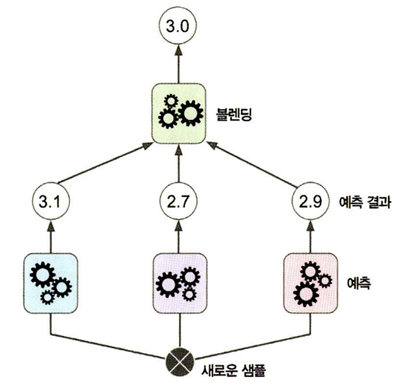

아래의 세 예측기는 각각 다른 값을 예측하고 마지막 예측기(blender 또는 meta model이라고 함)가 이 예측을 받아 최종예측을 함